# Assignment 3: Graph features & unsupervised node embedding

Ortal Senouf (ortal.senouf@epfl.ch), Ping Hu (ping.hu@epfl.ch)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%env PYTHONHASHSEED=0
import numpy as np
#!pip install stellargraph
from gensim.models import Word2Vec
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from IPython.display import clear_output 
import pandas as pd
clear_output()


## Data loading and visualization
We will use the PolBooks dataset consisting of 105 nodes and 441 edges.  
Nodes represent books about US politics sold by the online bookseller
Amazon.com.  Edges represent frequent co-purchasing of books by the same buyers, as indicated by the "customers who bought this book also bought these other books" feature on Amazon.

Nodes have been given values "l", "n", or "c" to indicate whether they are "liberal", "neutral", or "conservative".

In [ ]:
user = "rabbanyk"
repo = "CommunityEvaluation"
src_dir = "Datasets/classics"
pyfile = "polbooks.gml"

url = f"https://raw.githubusercontent.com/{user}/{repo}/master/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url}
G = nx.read_gml('polbooks.gml')

clear_output()

In [ ]:
# Name the graph
G.graph["name"] = 'Polbooks'

# The size of the graph
number_of_nodes = G.number_of_nodes()
print(number_of_nodes)
number_of_edges = G.number_of_edges()
print(number_of_edges)

105
441


In [ ]:
# Get the node lists for each label
values = nx.get_node_attributes(G, "value")
node_list_l = [k for k, v in values.items() if v == 'l']
node_list_n = [k for k, v in values.items() if v == 'n']
node_list_c = [k for k, v in values.items() if v == 'c']

In [ ]:
# Get edges connecting nodes with the same values and with distinct values
edge_list_l = [(k, v) for (k, v) in G.edges() if k in node_list_l and v in node_list_l] 
edge_list_n = [(k, v) for (k, v) in G.edges() if k in node_list_n and v in node_list_n] 
edge_list_c = [(k, v) for (k, v) in G.edges() if k in node_list_c and v in node_list_c] 
edge_list_between = [(k, v) for (k, v) in G.edges() if (k, v) not in (edge_list_l + edge_list_n + edge_list_c)]

Let's visualize the Polbooks network with nodes and edges colored by class: red for liberal nodes and edges connecting liberal nodes, blue for conservative and green for neutral.

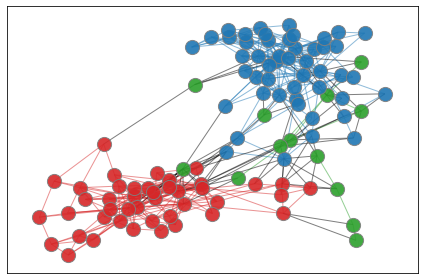

In [ ]:
# Plot the graph structure with colors
pos = nx.spring_layout(G, seed=0)

# nodes
options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist= node_list_l, node_color="tab:red", **options)
nx.draw_networkx_nodes(G, pos, nodelist= node_list_n, node_color="tab:green", **options)
nx.draw_networkx_nodes(G, pos, nodelist= node_list_c, node_color="tab:blue", **options)
# edges
nx.draw_networkx_edges(G, pos, edgelist = edge_list_l, width=1.0, alpha=0.5, edge_color="tab:red")
nx.draw_networkx_edges(G, pos, edgelist = edge_list_n, width=1.0, alpha=0.5, edge_color="tab:green")
nx.draw_networkx_edges(G, pos, edgelist = edge_list_c, width=1.0, alpha=0.5, edge_color="tab:blue")
nx.draw_networkx_edges(G, pos, edgelist = edge_list_between, width=1.0, alpha=0.5)
plt.tight_layout()

## Part I: Traditional Methods for ML on Graphs
####In this part you will extract some of the known node features and train a classifier for the task of node classification.

**Exercise 1**: Think of the various node features learned in class and select the two you expect to be the most meaningful in our node classification task. Explain. 


---
In our opinion, the most important feature would be the closeness centrality because it measures if a node is strongly connected and is between other nodes. This information could be useful as we notice that the classes form a few major and separable clusters. Therefore if a node is well connected or between nodes of a certain class then it is likely to belong to that class.

The second feature could be node degree as high degree nodes are very likely to belong to the same class as their neighbors since the nodes seem to have a high connectivity within their class.
 
---



**Exercise 2:** write a function that takes a graph object as an input and returns a matrix of size Nxd, where N is the number of nodes and d is the number of features. In this exercise you will extract the following features:degree, 3 node centrality measures, clustering coefficient. You may use NetworkX implementations for extracting these features.    

In [ ]:
def extract_features(G):
    degrees = [val for (node, val) in G.degree()]
    between_centrality = list(nx.betweenness_centrality(G).values()) 
    close_centrality = list(nx.closeness_centrality(G).values())     #normalised compared to course formula
    eigen_centrality = list(nx.eigenvector_centrality(G,1000).values())
    clustering_coef = list(nx.clustering(G).values())
    Features = np.array([degrees,between_centrality,close_centrality,eigen_centrality,clustering_coef]).T

    return Features

In [ ]:
# Get the nodes features and labels 
features_graph = extract_features(G)
print(features_graph.shape)
targets = [nx.get_node_attributes(G, "value")[node] for node in G.nodes()]

(105, 5)


**Exercise 3**: 

Write a function that: 
1.   Split the data into train and test sets, test should be 25% of the data. Use the random seed given in the code block. Make sure the data partition is stratified. **This part has already been done for you.**
2.   Train an SVM classifier on the train samples. Make sure to normalize the features and use the given random seed to define the `random_state` 
. Implement a feature selection preprocessing step before training to use the k highest scored features for the classification task. You may use the SelectKBest model together with the f_classif function from the `sklearn.feature_selection` library. 
3. Predict the labels of the test samples
4. Display the confusion matrix to evaluate the performance

You may use the `sklearn` library.



In [ ]:
from sklearn.model_selection import train_test_split
# additional imports are necessary
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import f_classif

def train_classifier(features, targets, feature_selection = False):
  ''' INPUT:
     features: Nxd features matrix
     targets: node labels
     feature_selection: a flag for weather to use feature selction, default is False. If an integer number is given than it is used as the number of highest ranked features to use
     OUTPUT:
     confmat: confusion matrix
     scores: feature ranking scores'''

  seed = 0 #Don't change this
  # split the data into training and testing sets

  X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, test_size=0.25, random_state = seed)


  # build and train the ML model
    # Your code here   
  scaler = StandardScaler()
  normalized_train = scaler.fit_transform(X_train)
  normalized_test = scaler.fit_transform(X_test)

  if feature_selection:
      k = feature_selection
      kbest = SelectKBest(f_classif, k=k)
      normalized_train = kbest.fit_transform(normalized_train, y_train)
      scores = kbest.scores_
      k_index = scores.argsort()[-3:][::-1]  
      normalized_test = normalized_test[:,np.sort(k_index)]


    #     clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf = SVC()
  clf.fit(normalized_train, y_train)

    # use the model to predict the labels of the test data
    # Your code here

  y_preds = clf.predict(normalized_test)

  confmat = confusion_matrix(y_test, y_preds)

  # Display the confusion matrix
  # Your code here
  print("confusion matrix: \n {}".format(confmat))
  if feature_selection:
    return confmat, scores
  else:
    return confmat

Run the `train_classifier` function with the feature selection module with feature_selection=3 (number of highest ranked features to use)

In [ ]:
# your code here
confmat, scores = train_classifier(features_graph, targets, feature_selection = 3)

confusion matrix: 
 [[13  0  0]
 [ 3  8  0]
 [ 2  1  0]]


Now run the `train_classifier` function without feature selection and observe if there's a diffrence in the performance.

In [ ]:
# your code here
confmat_no_feat_selec = train_classifier(features_graph, targets, feature_selection = False)

confusion matrix: 
 [[13  0  0]
 [ 3  8  0]
 [ 2  1  0]]


**Exercise 4:**
From the result of feature selection, which feature is the most important one for the classification task? Does it match your expectation in the first question? Explain.

---
The most important feature is the eigenvector centrality. As expected, it is a centrality feature that matters the most as it indicates if a node is well connected, and well connected nodes usually have nieghbors that are similar to their class.
 
---


**Exercise 5:**
In this part, we considered five classical node features that are easy to get from the networkx library. There are many other node features that can be employed for the node classification task. Recall the the lecture: what does the clustering coefficient measure? By which other more flexible feature can you replace it?

---
The clustering coefficient measures how tightly clustered a node’s neighborhood is, meaning the proportion of closed triangles there is in a neighborhood. This feature doesn't seem to matter much in our case because as long as the books form lineraly separable clusters, we do not care if the clusters are tight or not.
We can try to replace that feature with some graph level features instead of node level, like the WL Kernel.

 
---
   

### Part II: Node Embedding

In this part you will practice and analyze the unsupervised node embedding learning approach for the task of node classification. 

**Exercise 6**: What are the two steps of which the node2vec methods are built upon? 


---


 <font color='blue'>[YOUR ANSWER HERE]</font> 
 
The first step is a biased random walk controlled by the return parameter $p$ and the in-out parameter $q$. 

The second step consists in giving the sampled random walks as input to an encoder which generates the low dimension nodes embeddings in the latent vector space.

---



**Exercise 7**: Implement node2vec considering the two steps mentioned before. You may use the `gensim` and `stellargraph` libraries already installed and imported to this notebook. <br> 
**Complete** the explanation of p,q in the code documentation, i.e what they stand for and what values should be parsed to them <br>
**Make sure** to parse the given random seed whenever possible for reproducibility of results.  

In [ ]:
def Node2Vec(G, dimensions, walk_length, num_walks, p=1.0, q=10.0):
    '''G: NetworkX graph object
    dimensions: embedding dimensions
    walk_length: maximum length of each random walk
    num_walks: total number of random walks per root node
    p: probability of returning to source node
    q: probability of leaving the source node's neighborhood
    '''
    seed = 0
    #Your code here

    rw = BiasedRandomWalk(G, seed=seed)
    
    walks = rw.run(nodes=G.nodes(), length=walk_length, n=num_walks, p=p, q=q, weighted=True, seed=seed)
        
    model = Word2Vec(sentences=walks, vector_size=dimensions, 
                     window=walk_length, min_count=1, seed=seed)

    return model

In [ ]:
# Train the embedding
model = Node2Vec(StellarGraph.from_networkx(G), dimensions=3, walk_length=10, num_walks=50, p=1.0, q=10.0)

In [ ]:
# Display the embedding vector of one node
model.wv.get_vector('1000 Years for Revenge')

array([-1.3940471,  2.83856  ,  2.3488748], dtype=float32)

**Exercise 8**: similarly to the first part of the assignment, train an SVM classifier, this time with the embedding features. <br>
Use the `train_classifier` function you have implemented before. <br>
**Make sure** to stack the embedding vectors in the feature matrix in the same order as in Part I, i.e the order of the nodes in the row dimension (N) is maintained the same as in the feature matix of Part I. This will allow an identical split of the data into train and test sets and by that, allow the comaprison to the previous experiment with classical node features.  

In [ ]:
# Take the targets in the right order
nodes_key = model.wv.index_to_key 
targets_n2v1 = [nx.get_node_attributes(G, "value")[node] for node in nodes_key] 

In [ ]:
# stack the embedding features into a Nxd matrix (N: number of nodes, d: number of features)
features_n2v1 = model.wv.vectors #your code here
_ = train_classifier(features_n2v1, targets_n2v1)

confusion matrix: 
 [[13  0  0]
 [ 0 11  0]
 [ 2  0  1]]


**Exercise 9**: The previous embedding is trained with paramteres p=1.0,q=10.0. For the task of node classification on the Polbooks network which set of parameters whould you choose: <br>
[p=1.0, q=0.1] or [p=1.0, q=100.0] ? <br>
**Explain**.


---
 <font color='blue'>[YOUR ANSWER HERE]</font> 

Since books with common labels are strongly connected, we want the probability to stay in the neighborhood ($\propto $p) to be larger than the probability to go away from the initial node ($\propto $q) so that the sequences generated by the random walks are similar for nodes of the same class. Therefore, q has to be smaller that p. As a result, we would choose [p=1.0, q=0.1].

---



**Exercise 10**: repeat the experiment with the chosen p,q (train the embedding and the classifier). Keep the other parameters the same.

In [ ]:
model = Node2Vec(StellarGraph.from_networkx(G), dimensions=3, walk_length=10, num_walks=50, p=1., q=0.1)
features_n2v2 = model.wv.vectors #you code here
nodes_key = model.wv.index_to_key
targets_n2v2 = [nx.get_node_attributes(G, "value")[node] for node in nodes_key]
_ = train_classifier(features_n2v2,targets_n2v2)

confusion matrix: 
 [[12  0  1]
 [ 0 11  0]
 [ 0  1  2]]


**Exercise 11**: Display 3D scatter plots of each type of embedding: top3 ranked classical features and the two node2vec embeddings. Make sure the color of each node corresponds with its class ("c":blue, "l": red, "n":green). What do you observe?


---

We observe that the embedding obtained with the classical top 3 features leads to a good separability between the classes (specially the liberal and conservative books) allowing a good SVM classification. Unfortunately the neutral books still seem to mix up with the other classes, hence the errors in the confusion matrix.
As we could expect, the Node2Vec embedding outperforms the hand-crafted features and particularly, the second method with [p=1.0, q=0.1] leads to the best inter-class separability which can be observed in the last plot below.


---



Text(0.5, 0.92, 'Node2Vec 2')

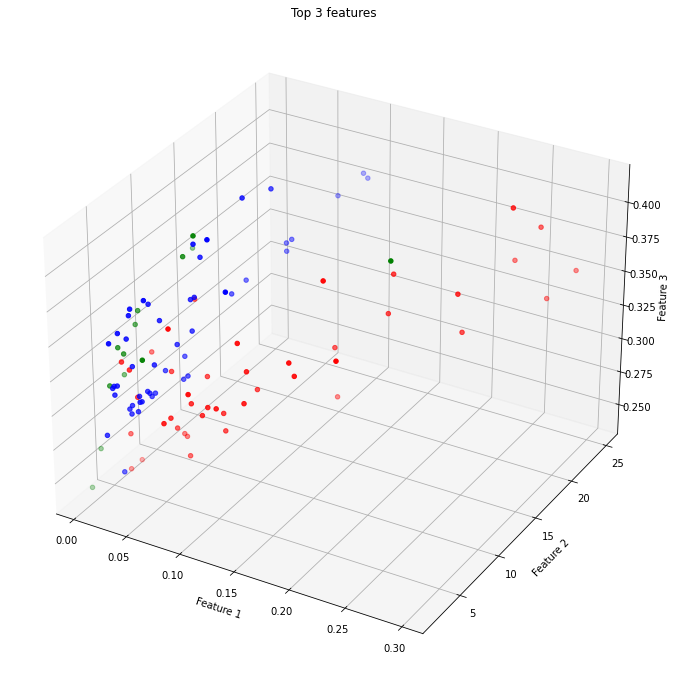

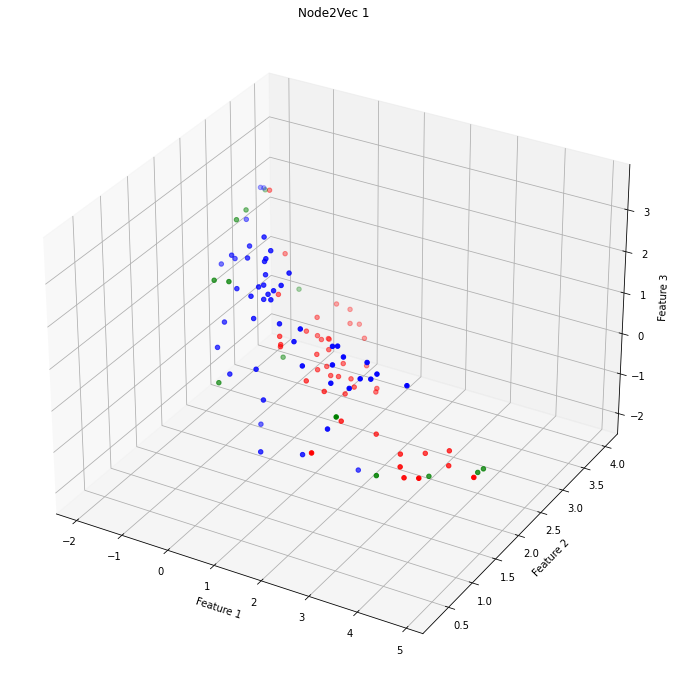

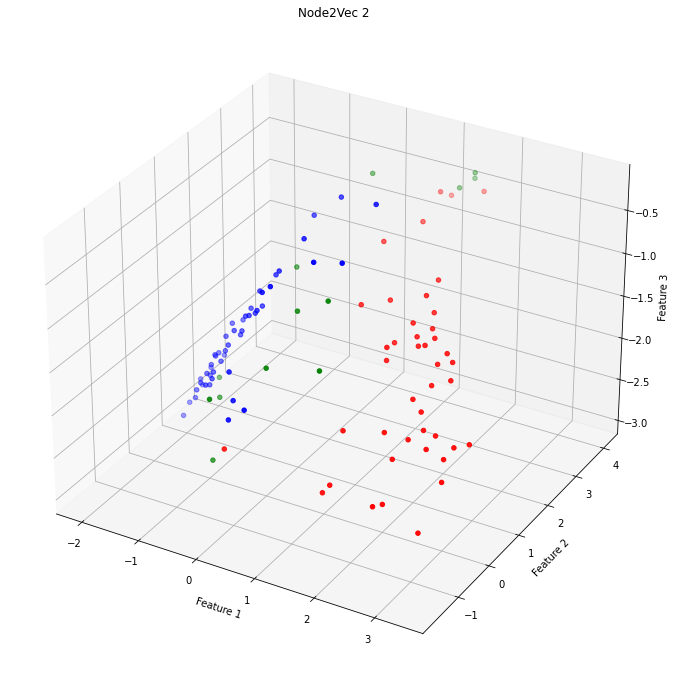

In [ ]:
# Your code here
top3 = features_graph[:,scores.argsort()[-3:][::-1]]

mask_n = []
mask_c = []
mask_l = []
mask_n_n2v1 = []
mask_c_n2v1 = []
mask_l_n2v1 = []
mask_n_n2v2 = []
mask_c_n2v2 = []
mask_l_n2v2 = []

for i in range(len(targets)):
    mask_n.append(targets[i] == "n")
    mask_c.append(targets[i] == "c")
    mask_l.append(targets[i] == "l")
    
    mask_n_n2v1.append(targets_n2v1[i] == "n")
    mask_c_n2v1.append(targets_n2v1[i] == "c")
    mask_l_n2v1.append(targets_n2v1[i] == "l")
    
    mask_n_n2v2.append(targets_n2v2[i] == "n")
    mask_c_n2v2.append(targets_n2v2[i] == "c")
    mask_l_n2v2.append(targets_n2v2[i] == "l")
    

cons_top3 = top3[mask_c]
lib_top3 = top3[mask_l]
neut_top3 = top3[mask_n]

cons_features_n2v1 = features_n2v1[mask_c_n2v1]
lib_features_n2v1 = features_n2v1[mask_l_n2v1]
neut_features_n2v1 = features_n2v1[mask_n_n2v1]

cons_features_n2v2 = features_n2v2[mask_c_n2v2]
lib_features_n2v2 = features_n2v2[mask_l_n2v2]
neut_features_n2v2 = features_n2v2[mask_n_n2v2]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(cons_top3[:,0], cons_top3[:,1], cons_top3[:,2], color="b")
ax.scatter(neut_top3[:,0], neut_top3[:,1], neut_top3[:,2], color="g")
ax.scatter(lib_top3[:,0], lib_top3[:,1], lib_top3[:,2], color="r")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Top 3 features")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(cons_features_n2v1[:,0], cons_features_n2v1[:,1], cons_features_n2v1[:,2], color="b")
ax.scatter(neut_features_n2v1[:,0], neut_features_n2v1[:,1], neut_features_n2v1[:,2], color="g")
ax.scatter(lib_features_n2v1[:,0], lib_features_n2v1[:,1], lib_features_n2v1[:,2], color="r")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Node2Vec 1")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(cons_features_n2v2[:,0], cons_features_n2v2[:,1], cons_features_n2v2[:,2], color="b")
ax.scatter(neut_features_n2v2[:,0], neut_features_n2v2[:,1], neut_features_n2v2[:,2], color="g")
ax.scatter(lib_features_n2v2[:,0], lib_features_n2v2[:,1], lib_features_n2v2[:,2], color="r")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Node2Vec 2")


**Exercise 12**: Amazon has expanded the PolBooks network and new books nodes are added to the graph. They ask you as their machine learning researcher to discover their category (liberal, conservative or neutral). What should you do? 


---
As we obtained the best results with our second Node2Vec method, we can simply use it to embedd the new nodes and then apply our trained SVM to predict the classes of the new books. 


---
